# Introduction

This notebook implement a Deep Recurrent Q-learning Network for automated stock trading as presented in:  
- L. Chen and Q. Gao, "Application of Deep Reinforcement Learning on Automated Stock Trading," 2019.  
https://ieeexplore-ieee-org.ezproxy.universite-paris-saclay.fr/document/9040728 

### Parameters

The deep Q-network contains 4 layers and the number of 
units for each layer is 20,10,10 and 3 respectively. We use ReLU 
as the activation function. The learning rate is set to be 
exponential decayed every 100 steps on the training dataset and 
the initial rate is 0.001, while on the test dataset, the learning rate 
is set as a fixed value 0.001. For the Q-learning part, the discount 
factor is set to y = 0.79, this value is quite small because the 
problem we defined is a short-term daily trading process so that 
we pay more attention to current reward. The max $\epsilon$ is set to 
0.99 and start with 0. The batch size is set to 100 and the 
parameters for target network $\widetilde{Q}$ is replaced every 100 
iterations. As for the DRQN model, the time step is set to 20, 
and the number of RNN units is set to 6 .

In [1]:
ENV_STATE_DEPTH = 20 # from paper

NUM_EPISODE = 10 # from paper

HIDDEN_DIMS = [20, 10, 10] # from paper

LR_DECAY_FREQ = 100 # from paper
LR = 0.001 # from paper
TEST_LR = 0.001 # from paper
LR_DECAY = 0.99

DISCOUNT_FACTOR = 0.79 # from paper

EPS_MIN = 0.01 # from paper
EPS_START = 1.0 # from paper
EPS_DECAY = 0.9995

BATCH_SIZE = 100 # from paper
MEMORY_SIZE = 10000

TARGET_UPDATE_FREQUENCY = 100 # from paper

LSTM_TIME_STEP = 20 # from paper
NUM_RNN_UNITS = 6 # from paper

# Imports

In [2]:
import sys
sys.path.append("./src")

In [3]:
from collections import namedtuple, deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
import yfinance as yf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Data

[*********************100%%**********************]  1 of 1 completed


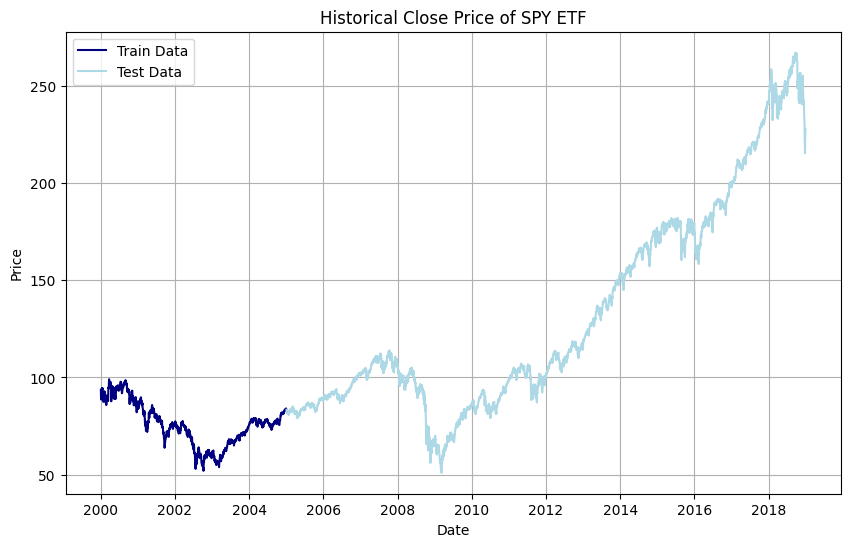

In [4]:
ticker_symbol = 'SPY'

spy_data = yf.download(ticker_symbol, start='2000-01-01', end='2018-12-31')
spy_data

train_data = spy_data[spy_data.index < "2005-01-01"]
test_data = spy_data[spy_data.index >= "2005-01-01"]

train_data = train_data["Adj Close"]
test_data = test_data["Adj Close"]

plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Train Data', color='navy')
plt.plot(test_data.index, test_data, label='Test Data', color='lightblue')
plt.title('Historical Close Price of SPY ETF')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
train_data

Date
2000-01-03    93.591141
2000-01-04    89.931175
2000-01-05    90.092026
2000-01-06    88.644119
2000-01-07    93.792267
                ...    
2004-12-27    83.516823
2004-12-28    83.974182
2004-12-29    84.098892
2004-12-30    83.939499
2004-12-31    83.759338
Name: Adj Close, Length: 1256, dtype: float64

# Environment

In [6]:
import numpy as np
import random

import gymnasium as gym
from gymnasium import spaces


class TradingEnv(gym.Env):
    def __init__(self, data, state_dim=20):
        """
        Initialize the trading environment
        """
        super(TradingEnv, self).__init__()

        self.data = data

        self.current_step = None
        self.state = None
        self.cumulative_reward = None

        self.action_space = spaces.Discrete(3)
        self.action_dic = {0: -1, 1: 0, 2: 1}  # sell  # hold  # buy

        self.observation_space = spaces.Box(
            low=np.array([0] * state_dim),
            high=np.array([np.inf] * state_dim),
            dtype=np.float32,
        )

        self.action_dim = self.action_space.n
        self.state_dim = self.observation_space.shape[0]

        self.reset()

    def reset(self):
        """
        Reset the trading environment
        """
        self.current_step = 0
        self.state = self.data.iloc[
            self.current_step : self.state_dim + self.current_step
        ]
        self.cumulative_reward = 0
        self.done = False

        return self.state

    def compute_reward(self, state, new_state, action):
        """
        Calculate the reward based on the change in balance, position, and trading action.
        """
        price = state.iloc[-1]
        new_price = new_state.iloc[-1]
        reward = (new_price - price) * action
        return reward

    def is_done(self):
        if self.state_dim + self.current_step == len(self.data):
            return True
        else:
            return False

    def step(self, action):
        """
        Take a step in the trading environment
        """
        self.current_step += 1

        # State
        state = self.state

        # New state
        new_state = self.data.iloc[
            self.current_step : self.state_dim + self.current_step
        ]

        # Reward
        reward = self.compute_reward(state, new_state, self.action_dic[action])
        self.cumulative_reward += reward

        # Done
        self.done = self.is_done()

        # Info
        self.info = {
            "step": self.current_step,
            "price": state.iloc[-1],
            "action": self.action_dic[action],
            "new_price": new_state.iloc[-1],
            "reward": self.cumulative_reward,
            "done": self.done,
        }

        self.state = new_state

        return self.state, reward, self.done, self.info

    def render(self):
        """
        Print the current state
        """
        print(f"current step: {self.current_step}")
        print(f"state: {self.state}")
        print(f"state shape: {self.state.shape}")

    def run_backtest(self, policy):
        """
        Run a full backtest of the trading environment using the provided policy.
        The policy function should take a state as input and return an action.
        """
        self.reset()
        history = []
        while not self.done:
            action = policy(self.state)
            self.step(action)
            history.append(self.info)
        return history

In [7]:
print("##### Test Buy #####")
toy_env = TradingEnv(train_data, 20)
state_1 = toy_env.state
print(f"Price: {round(state_1.iloc[-1], 2)}")
toy_env.step(2)
state_2 = toy_env.state
print(f"New price: {round(state_2.iloc[-1], 2)}")
print(f"Cumulative reward: {round(toy_env.cumulative_reward, 2)}")
assert toy_env.cumulative_reward == (train_data.iloc[20] - train_data.iloc[19]) * 1

print("\n")

print("##### Test Sell #####")
toy_env = TradingEnv(train_data, 20)
state_1 = toy_env.state
toy_env.step(0)
print(f"Price: {round(state_1.iloc[-1], 2)}")
state_2 = toy_env.state
print(f"New price: {round(state_2.iloc[-1], 2)}")
print(f"Cumulative reward: {round(toy_env.cumulative_reward, 2)}")
assert toy_env.cumulative_reward == (train_data.iloc[20] - train_data.iloc[19]) * -1

print("\n")

print("##### Test Hold #####")
toy_env = TradingEnv(train_data, 20)
state_1 = toy_env.state
print(f"Price: {round(state_1.iloc[-1], 2)}")
toy_env.step(1)
state_2 = toy_env.state
print(f"New price: {round(state_2.iloc[-1], 2)}")
print(f"Cumulative reward: {round(toy_env.cumulative_reward, 2)}")
assert toy_env.cumulative_reward == (train_data.iloc[20] - train_data.iloc[19]) * 0


##### Test Buy #####
Price: 89.81
New price: 90.7
Cumulative reward: 0.88


##### Test Sell #####
Price: 89.81
New price: 90.7
Cumulative reward: -0.88


##### Test Hold #####
Price: 89.81
New price: 90.7
Cumulative reward: 0.0


# Strategies

In [8]:
def eval(env, policy):

    if isinstance(policy, nn.Module):
        policy.eval()

    history = []

    total_step_count = 0
    state = torch.tensor(env.reset(), dtype=torch.float32, device=device).unsqueeze(
        0
    )

    while not env.done:
        total_step_count += 1

        action = policy(state)
        if isinstance(policy, nn.Module):
            action = action.max(1).indices.view(1, 1).item()
            
        next_state, _, _, _ = env.step(action)
        
        next_state = torch.tensor(
            next_state, dtype=torch.float32, device=device
        ).unsqueeze(0)

        state = next_state
        history.append(env.info)

    return history

In [9]:
def visualize(prices, actions):
    buy_signals = []
    sell_signals = []

    for i in range(len(prices)):
        if actions[i] == 1:
            buy_signals.append(prices[i])
            sell_signals.append(None)
        elif actions[i] == -1:
            buy_signals.append(None)
            sell_signals.append(prices[i])
        else:
            buy_signals.append(None)
            sell_signals.append(None)

    plt.figure(figsize=(10, 6))
    plt.plot(prices, color='blue', label='Price')
    plt.scatter(prices.index, buy_signals, color='green', label='Buy Signal', zorder=5)
    plt.scatter(prices.index, sell_signals, color='red', label='Sell Signal', zorder=5)
    plt.title('Price with Buy/Sell Signals')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

### Buy and Hold

In [10]:
def bh_policy(state):
    """
    To reproduce the buy and hold strategy with the current environment we consider a systematic buy strategy.
    """
    return 2

### DQN

In [11]:
# class DQN(nn.Module):
#     def __init__(self, input_size, output_size, hidden_dims):
#         super(DQN, self).__init__()
#         self.hidden_layers = nn.ModuleList([
#             nn.Linear(input_size, hidden_dims[0])
#         ])
#         for i in range(len(hidden_dims) - 1):
#             self.hidden_layers.extend([
#                 nn.Linear(hidden_dims[i], hidden_dims[i+1]) 
#             ])
#         self.output_layer = nn.Linear(hidden_dims[-1], output_size)

#     def forward(self, x):
#         for layer in self.hidden_layers:
#             x = F.relu(layer(x))
#         x = self.output_layer(x)
#         return x
    
    

### DRQN

In [12]:
class DRQN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims, lstm_units):
        super(DRQN, self).__init__()

        self.lstm = nn.LSTM(input_size, lstm_units, batch_first=True)

        self.hidden_layers = nn.ModuleList([
            nn.Linear(lstm_units, hidden_dims[0])
        ])
        for i in range(len(hidden_dims) - 1):
            self.hidden_layers.extend([
                nn.Linear(hidden_dims[i], hidden_dims[i+1]) 
            ])
        self.fc = nn.Linear(hidden_dims[-1], output_size)

    def forward(self, x):
        """
        x.shape: (batch_size, seq_length, input_size)
        h_0.shape: (num_layers * num_directions, batch_size, lstm_units)
        c_0.shape: (num_layers * num_directions, batch_size, lstm_units)
        """
        if len(x.shape) == 2: # (batch_size, seq_length)
            x = x.unsqueeze(1)
        batch_size = x.size(0)
        
        h_0 = torch.zeros(1, batch_size, self.lstm.hidden_size)
        c_0 = torch.zeros(1, batch_size, self.lstm.hidden_size)
        x, _ = self.lstm(x, (h_0, c_0))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.fc(x)
        x = x.squeeze(1)
        return x

In [13]:
drqn_test = DRQN(20, 3, [20, 10, 10], 6)

assert isinstance(drqn_test, nn.Module)

drqn_test

DRQN(
  (lstm): LSTM(20, 6, batch_first=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=6, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
  (fc): Linear(in_features=10, out_features=3, bias=True)
)

# Replay memory

In [14]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.memory, batch_size))
        return np.array(state), action, reward, np.array(next_state), done

    def __len__(self):
        return len(self.memory)


# Train

### Greedy action

In [15]:
def update_epsilon(epsilon, decay_rate, min_epsilon):
    epsilon *= decay_rate
    epsilon = max(epsilon, min_epsilon)
    return epsilon

def record_explore_exploit(func):

    def wrapper(env, policy, state, epsilon):
        random_sample = np.random.rand()
        wrapper.epsilon_list.append(epsilon)
        if random_sample < epsilon:
            wrapper.action_list.append(0) 
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        else:
            wrapper.action_list.append(1) 
            return func(policy, state)

    wrapper.action_list = []
    wrapper.epsilon_list = []

    def reset_lists():
        wrapper.action_list = []
        wrapper.epsilon_list = []

    wrapper.reset_lists = reset_lists

    return wrapper

@record_explore_exploit
def epsilon_greedy_action(policy, state):
    with torch.no_grad():
        return policy(state).max(1).indices.view(1, 1)


9208


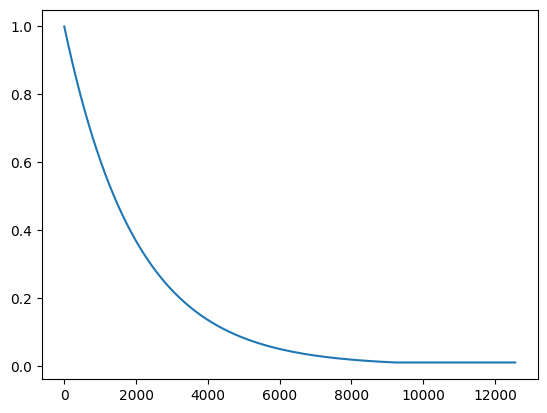

In [16]:
eps_test = EPS_START
eps_tests = []

found_threshold = False
for i in range(len(train_data) * NUM_EPISODE):
    eps_test = update_epsilon(eps_test, EPS_DECAY, EPS_MIN)
    eps_tests.append(eps_test)
    if not found_threshold and eps_test == 0.01:
        print(i)
        found_threshold = True

plt.plot(eps_tests)
plt.show()

### Train loop

In [45]:
def train(env, model, target_model, replay_memory, optimizer, scheduler, criterion):

    model.train()

    history = []
    logs = {"action": [], "epsilon": [], "learning_rate": []}
    wrapper_greedy_actions = []
    wrapper_epsilons = []

    total_step_count = 0
    epsilon = EPS_START
    
    for episode in tqdm(range(NUM_EPISODE)):

        epoch_history = []

        state = torch.tensor(env.reset(), dtype=torch.float32, device=device).unsqueeze(
            0
        )

        while not env.done:
            total_step_count += 1

            logs["epsilon"].append(epsilon)
            action = epsilon_greedy_action(env, model, state, epsilon)
            logs["action"].append(env.action_dic[action.item()])
            epsilon = update_epsilon(epsilon, EPS_DECAY, EPS_MIN)

            next_state, reward, done, _ = env.step(action.item())

            next_state = torch.tensor(
                next_state, dtype=torch.float32, device=device
            ).unsqueeze(0)
            reward = torch.tensor([reward], device=device)
            replay_memory.push(state, action, reward, next_state, done)

            state = next_state

            if len(replay_memory) > BATCH_SIZE:
                
                states, actions, rewards, next_states, dones = replay_memory.sample(
                    BATCH_SIZE
                )
                states = torch.tensor(states, dtype=torch.float32).squeeze(1)
                actions = torch.tensor(actions, dtype=torch.long)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.tensor(next_states, dtype=torch.float32)
                dones = torch.tensor(dones, dtype=torch.float32)

                states = states.squeeze(1)
                next_states = states.squeeze(1)
                actions = actions.unsqueeze(1)

                # print(f"states shape: {states.shape}")
                # print(f"actions shape: {actions.shape}")
                # print(f"rewards shape: {rewards.shape}")
                # print(f"next states shape: {next_states.shape}")

                state_action_values = model(states).gather(1, actions)
                next_state_values = target_model(next_states).max(1)[0].detach()
                expected_state_action_values = (
                    rewards + (1 - dones) * DISCOUNT_FACTOR * next_state_values
                )

                loss = criterion(
                    state_action_values, expected_state_action_values.unsqueeze(1)
                )

                logs["learning_rate"].append(optimizer.param_groups[0]["lr"])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (
                    total_step_count > BATCH_SIZE
                    and total_step_count % LR_DECAY_FREQ == 0
                ):
                    scheduler.step()

            if total_step_count % TARGET_UPDATE_FREQUENCY == 0:
                target_model.load_state_dict(model.state_dict())
            
            epoch_history.append(env.info)

        history.append(epoch_history)
        wrapper_epsilons.append(epsilon_greedy_action.epsilon_list)
        wrapper_greedy_actions.append(epsilon_greedy_action.action_list)

        epsilon_greedy_action.reset_lists()

    return history, logs, wrapper_epsilons, wrapper_greedy_actions

# Results

### Buy and hold

In [46]:
test_env = TradingEnv(test_data, state_dim=ENV_STATE_DEPTH)
num_observations = test_env.observation_space.shape[0]
num_actions = test_env.action_space.n

bh_history = eval(test_env, bh_policy)


bh_history_df = pd.DataFrame(bh_history)
bh_history_df.head()

,step,price,action,new_price,reward,done
0,1,81.881439,1,82.401115,0.519676,False
1,2,82.401115,1,82.650620,0.769180,False
2,3,82.650620,1,82.435791,0.554352,False
3,4,82.435791,1,83.315887,1.434448,False
4,5,83.315887,1,83.204956,1.323517,False


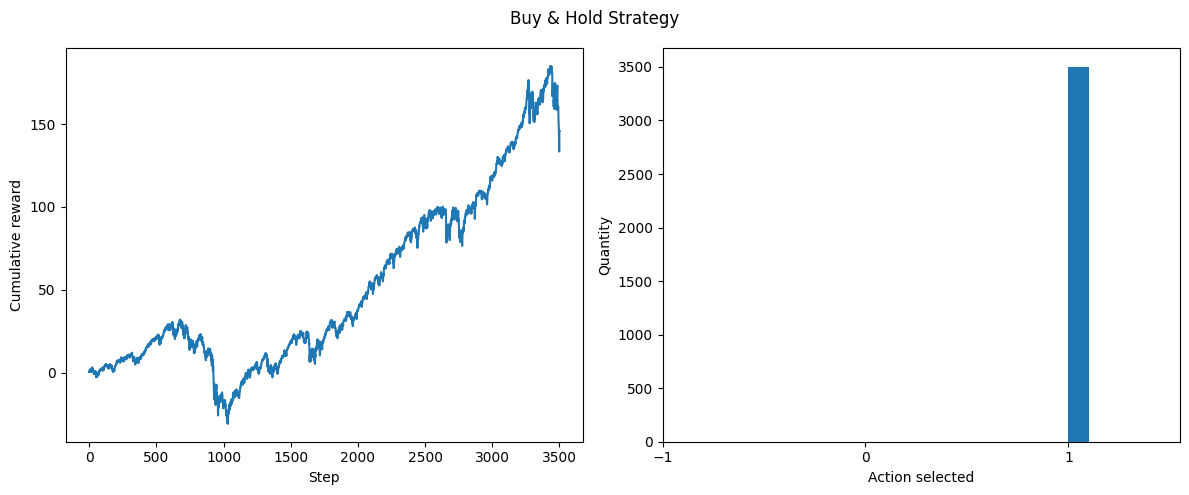

In [51]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(bh_history_df.reward)
plt.xlabel("Step")
plt.ylabel("Cumulative reward")

plt.subplot(1, 2, 2)
plt.hist(bh_history_df.action)
plt.xticks([-1, 0, 1])
plt.xlabel("Action selected")
plt.ylabel("Quantity")

plt.suptitle("Buy & Hold Strategy")
plt.tight_layout()
plt.show()

### DRQN

In [66]:
train_env = TradingEnv(train_data, state_dim=ENV_STATE_DEPTH)
num_observations = train_env.observation_space.shape[0]
num_actions = train_env.action_space.n

drqn = DRQN(num_observations, num_actions, HIDDEN_DIMS, NUM_RNN_UNITS).to(device)
target_drqn = DRQN(num_observations, num_actions, HIDDEN_DIMS, NUM_RNN_UNITS).to(device)
target_drqn.load_state_dict(drqn.state_dict())
target_drqn.eval()

replay_memory = ReplayMemory(MEMORY_SIZE)

drqn_optimizer = torch.optim.SGD(drqn.parameters(), lr=LR)
lr_scheduler = ExponentialLR(drqn_optimizer, gamma=LR_DECAY)

criterion = nn.MSELoss()

train_history, train_logs, wrapper_epsilons, wrapper_greedy_actions  = train(
    train_env, 
    model=drqn,
    target_model=target_drqn,
    replay_memory=replay_memory,
    optimizer=drqn_optimizer,
    scheduler=lr_scheduler,
    criterion=criterion
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:01<00:00,  6.13s/it]


##### Epsilon

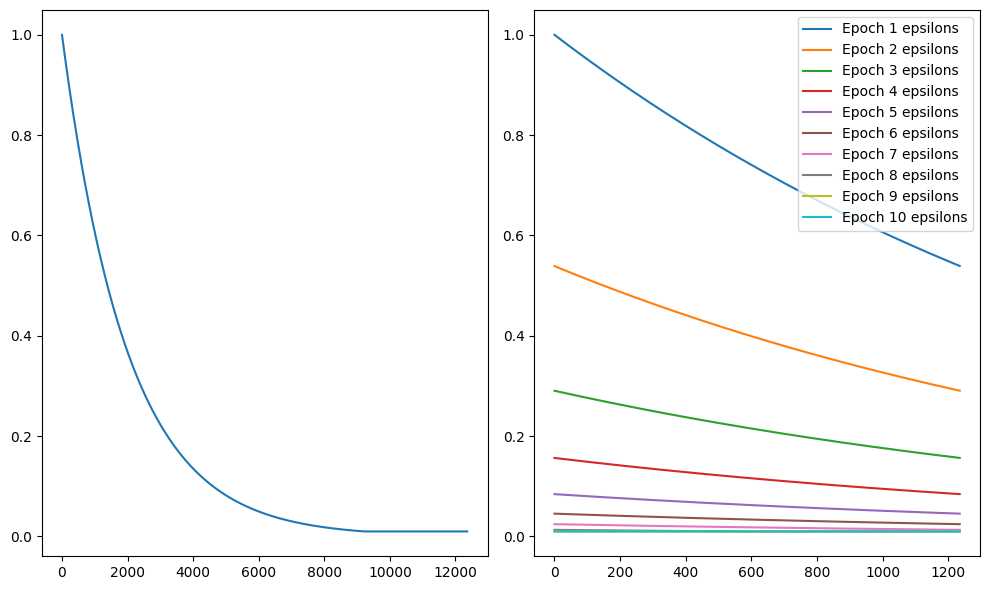

In [53]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(train_logs["epsilon"], label="Epsilons")

plt.subplot(1, 2, 2)
for i, epsilons in enumerate(wrapper_epsilons):
    plt.plot(epsilons, label=f"Epoch {i+1} epsilons")

plt.tight_layout()
plt.legend()
plt.show()


##### Exploration / Exploitation

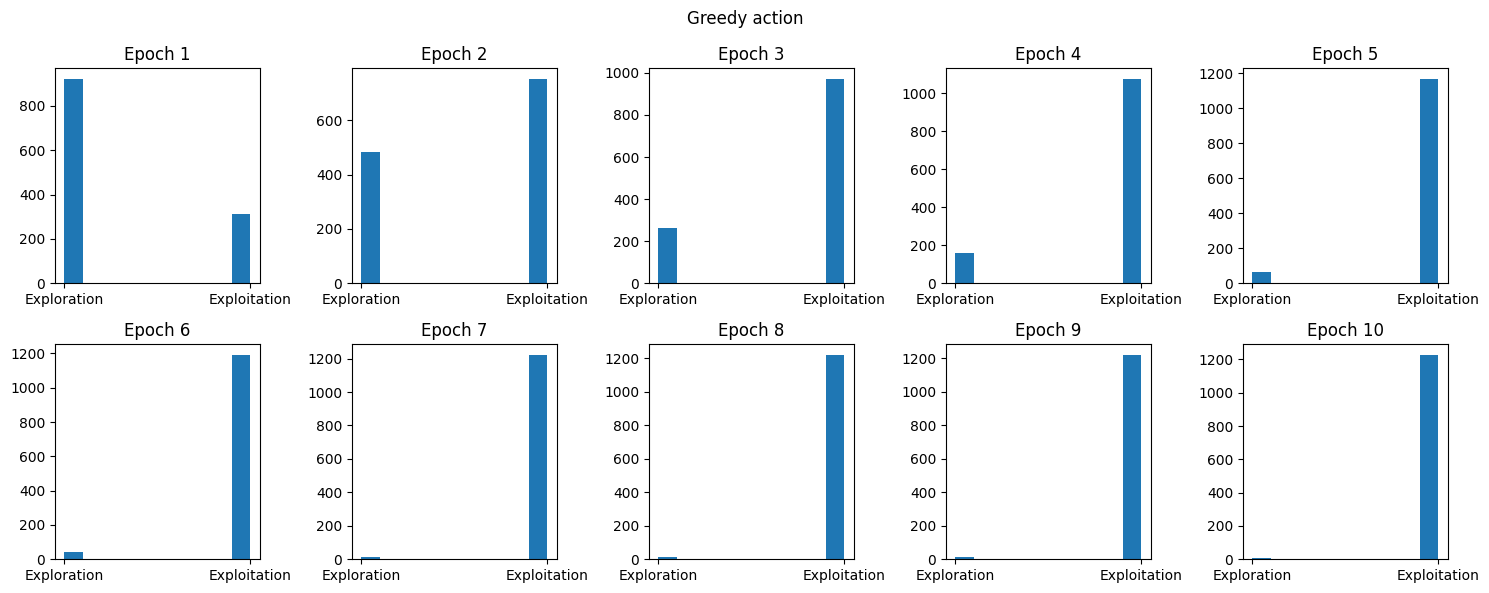

In [71]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, epoch_greedy_actions in enumerate(wrapper_greedy_actions):
    row = i // 5 
    col = i % 5  
    axes[row, col].hist(epoch_greedy_actions)
    axes[row, col].set_title(f"Epoch {i+1}")
    axes[row, col].set_xticks([0, 1])
    axes[row, col].set_xticklabels(["Exploration", "Exploitation"])

plt.suptitle("Greedy action")
plt.tight_layout()
plt.show()


##### Learning rates

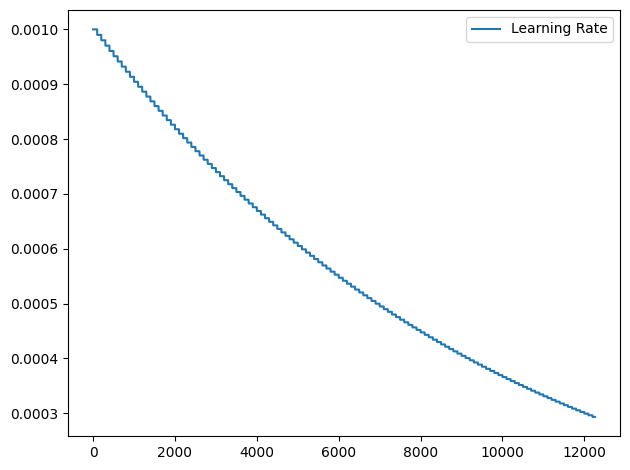

In [55]:
plt.plot(train_logs["learning_rate"], label="Learning Rate")
plt.legend()
plt.tight_layout()
plt.show()

##### Actions

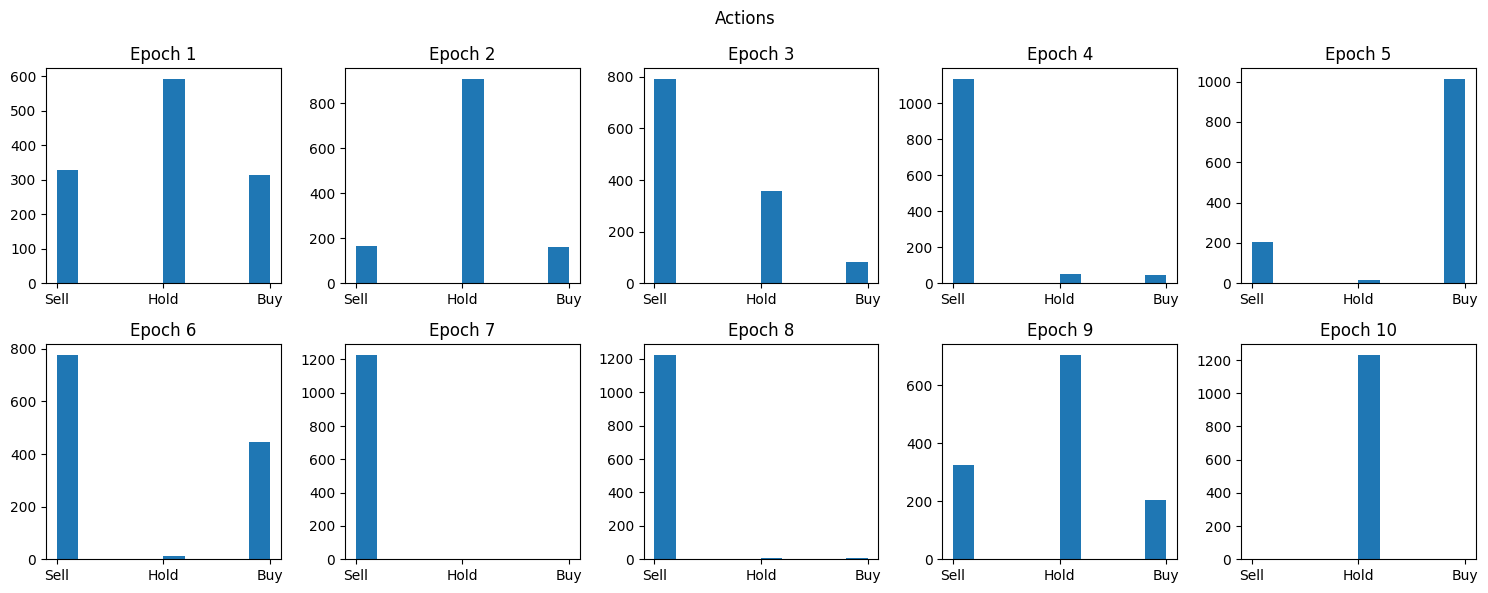

In [72]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, epoch_history in enumerate(train_history):
    row = i // 5 
    col = i % 5  
    axes[row, col].hist(pd.DataFrame(epoch_history).action)
    axes[row, col].set_title(f"Epoch {i+1}")
    axes[row, col].set_xticks([-1, 0, 1])
    axes[row, col].set_xticklabels(["Sell", "Hold", "Buy"])

plt.suptitle("Action")
plt.tight_layout()
plt.show()


##### Rewards

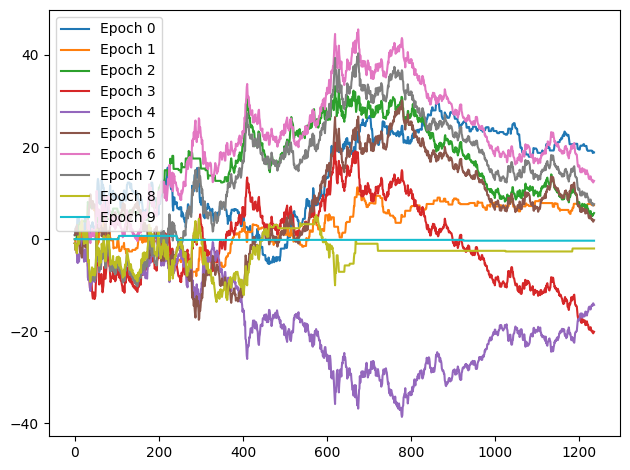

In [69]:
for i, epoch_history in enumerate(train_history):
    plt.plot(pd.DataFrame(epoch_history).reward, label=f"Epoch {i}")
plt.legend()
plt.tight_layout()
plt.show()

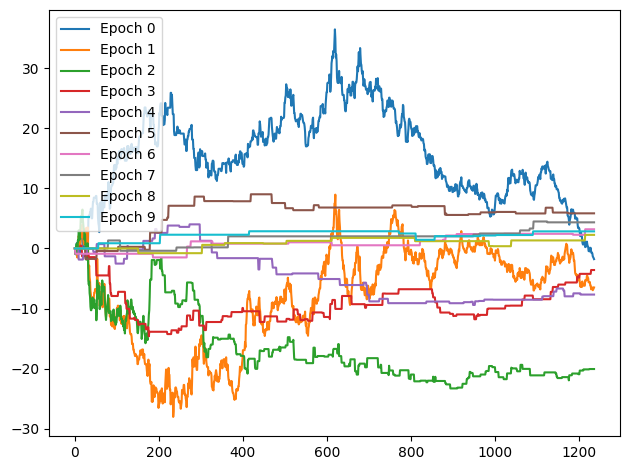

In [32]:
for i, epoch_rewards in enumerate(train_total_rewards):
    plt.plot(epoch_rewards, label=f"Epoch {i}")
plt.legend()
plt.tight_layout()
plt.show()

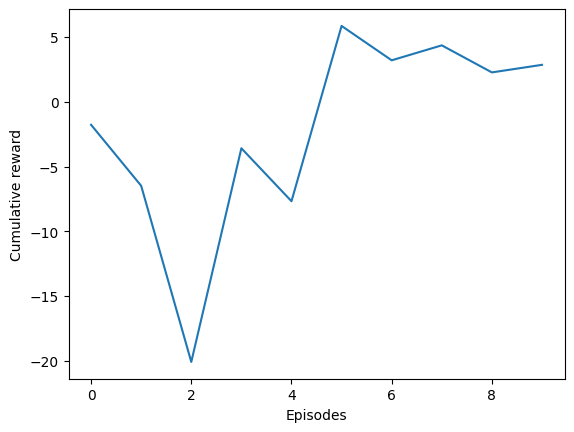

In [36]:
plt.plot([pd.DataFrame(epoch_history).reward.iloc[-1] for epoch_history in train_history])
plt.xlabel("Episodes")
plt.ylabel("Cumulative reward")
plt.show()

##### Eval

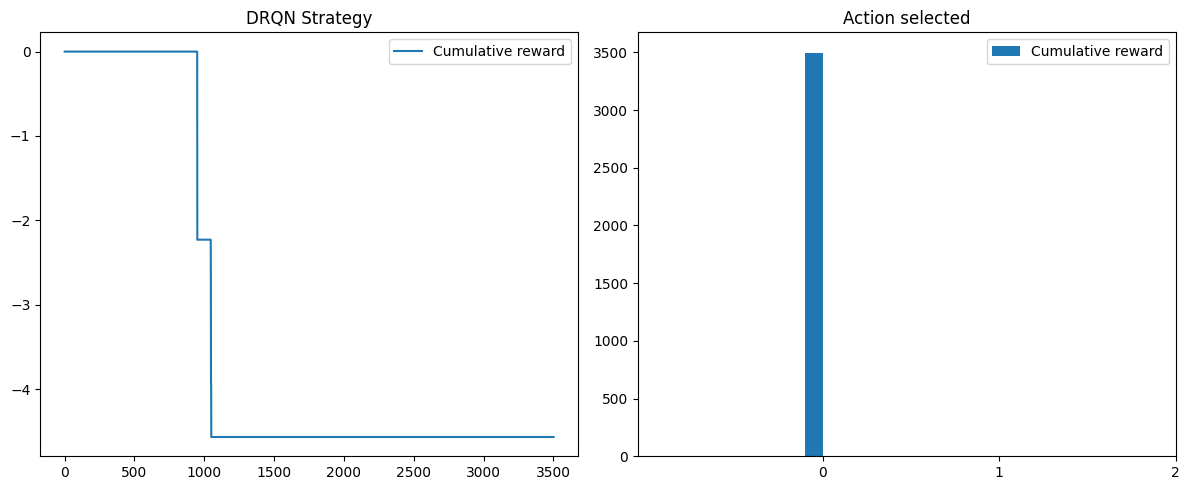

In [102]:
test_env = TradingEnv(test_data, state_dim=ENV_STATE_DEPTH)
num_observations = train_env.observation_space.shape[0]
num_actions = train_env.action_space.n


drqn_test_history  = eval(
    test_env, 
    policy=target_drqn
)

drqn_test_history_df = pd.DataFrame(drqn_test_history)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(drqn_test_history_df.reward, label="Cumulative reward")
plt.legend()
plt.title("DRQN Strategy")

plt.subplot(1, 2, 2)
plt.hist(drqn_test_history_df.action, label="Cumulative reward")
plt.xticks([0, 1, 2])
plt.legend()
plt.title("Action selected")

plt.tight_layout()
plt.show()

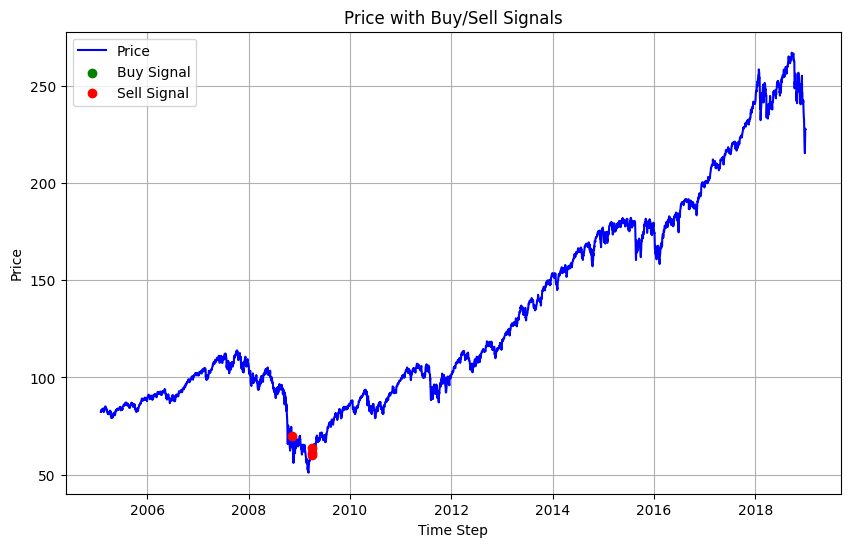

In [103]:
visualize(test_data.iloc[20:], drqn_test_history_df.action)